# 1 Import library

In [1]:
from matplotlib import pyplot as plt
import sklearn
import pandas as pd
import time

In [2]:
import numpy as np

In [3]:
from neo4j import GraphDatabase

In [4]:
from pandas import DataFrame

In [5]:
import json

In [6]:
from yfiles_jupyter_graphs import GraphWidget

In [7]:
import matplotlib

In [8]:
from graphdatascience import GraphDataScience

In [43]:
pip install graphdatascience

     ------------------------------------- 919.0/919.0 kB 14.7 MB/s eta 0:00:00
     ---------------------------------------- 20.2/20.2 MB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# 2 Load data and create database

In [9]:
data = pd.read_csv('data_test.csv')

In [10]:
data[:4]

,idEvent;FullName1;FullName2
0,189;Галчевская Карина Владимировна;Белоновская...
1,206;Офицеров Олег Романович;Сапожник Борис Вал...
2,445;Жандарова Лариса Германовна;Чемодуров Дами...
3,503;Масимова Яна Дамировна;Мингажетдинов Рамил...


In [11]:
#Создадим класс для подключения к базе данных
class Neo4jConnection:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        if self.driver is not None:
            self.driver.close()

# Метод, который передает запрос в БД и возвращает данные в виде списка
    def query(self, query, db=None):
        assert self.driver is not None, "Driver not initialized!"
        session = None
        response = None
        try:
            session = self.driver.session(database=db) if db is not None else self.driver.session()
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return response

# Метод, который передает запрос в БД и возвращает данные в виде графа
    def query_graph(self, query_graph, db=None):
        assert self.driver is not None, "Driver not initialized!"
        session = None
        response = None
        try:
            session = self.driver.session(database=db) if db is not None else self.driver.session()
            response = session.run(query_graph).graph()
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return response
    
# Метод, который передает запрос в БД и возвращает данные в виде json
    def query_json(self, query_json, db=None):
        assert self.driver is not None, "Driver not initialized!"
        session = None
        response = None
        try:
            session = self.driver.session(database=db) if db is not None else self.driver.session()
            response = session.run(query_json)
            data = response.data()
            data = json.dumps(data, ensure_ascii=False)
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return data
    
    
    # Метод, который передает запрос в БД c идентификатором и возвращает данные в виде json
    def query_json_id(self, query_json_id, parametrs, db=None):
        assert self.driver is not None, "Driver not initialized!"
        session = None
        response = None
        try:
            session = self.driver.session(database=db) if db is not None else self.driver.session()
            response = session.run(query_json_id, parametrs)
            data = response.data()
            data = json.dumps(data, ensure_ascii=False)
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return data
    

In [12]:
#Извлечем необходимые данные из ранее созданного файла(локалхост, узер, пароль) для покдлючения к базе данных. Проверим корректность извлечения.
with open('entrance.txt','r') as ent:
    data = ent.read().split(',')
uri_my = eval(data[0].split('=')[1])
user_my = eval(data[1].split('=')[1])
password_my = eval(data[2].split('=')[1])
user_my

'Ekaterina'

In [13]:
#Подключаемся к базе данных
conn = Neo4jConnection(uri=uri_my, user=user_my, password=password_my)

In [104]:
#Создаем пустую базу данных
conn.query("CREATE OR REPLACE DATABASE graphdb")

[]

In [ ]:
#Создаем ноды и свойства участник события, используя информацию из файла data_test.csv
#query_string = '''
#LOAD CSV WITH HEADERS FROM
#'https://raw.githubusercontent.com/KaterinaChel/grath-DB/main/data_test.csv'
#AS line FIELDTERMINATOR ';'
#MERGE (member:Member {fullname: line.FullName1})
#  ON CREATE SET member.idEvent = line.idEvent
#  ON MATCH SET member.idEvent2 = line.idEvent
#MERGE (member2:Member {fullname: line.FullName2})
#  ON CREATE SET member2.idEvent = line.idEvent
#  ON MATCH SET member2.idEvent2 = line.idEvent;
#  
#'''
#conn.query(query_string, db='graphdb')

In [105]:
#Создаем ноды и свойства участник события, используя информацию из файла data_test.csv
query_string = '''
LOAD CSV WITH HEADERS FROM
'https://raw.githubusercontent.com/KaterinaChel/grath-DB/main/data_test.csv'
AS line FIELDTERMINATOR ';'
MERGE (member:Member {fullname: line.FullName1})
  ON CREATE SET member.idEvent = line.idEvent
  on MATCH SET member.idEvent = apoc.convert.toSet(member.idEvent + [line.idEvent]) 
MERGE (member2:Member {fullname: line.FullName2})
  ON CREATE SET member2.idEvent = line.idEvent
  on MATCH SET member2.idEvent = apoc.convert.toSet(member2.idEvent + [line.idEvent]);
  
'''
conn.query(query_string, db='graphdb')

[]

In [106]:
#Создаем ноды и свойства событие, используя информацию из файла data_test.csv
query_string = '''
LOAD CSV WITH HEADERS FROM
'https://raw.githubusercontent.com/KaterinaChel/grath-DB/main/data_test.csv'
AS line FIELDTERMINATOR ';'
MERGE (event:Event {idEvent: line.idEvent})
  ON CREATE SET event.fullname1 = line.FullName1
  ON CREATE SET event.fullname2 = line.FullName2
  ON MATCH SET event.fullname3 = line.FullName1
  ON MATCH SET event.fullname4 = line.FullName2;
  
'''
conn.query(query_string, db='graphdb')

[]

In [30]:
#Создаем ноды и свойства событие, используя информацию из файла data_test.csv
#query_string = '''
#LOAD CSV WITH HEADERS FROM
#'https://raw.githubusercontent.com/KaterinaChel/grath-DB/main/data_test.csv'
#AS line FIELDTERMINATOR ';'
#MERGE (event:Event {idEvent: line.idEvent})
#  ON CREATE SET event.fullname1 = line.FullName1
#  ON CREATE SET event.fullname2 = line.FullName2
#  on MATCH SET event.fullname1 = apoc.convert.toSet(event.fullname1 + [line.FullName1])
#  on MATCH SET event.fullname2 = apoc.convert.toSet(event.fullname2 + [line.FullName2]);
  
#'''
#conn.query(query_string, db='graphdb')

[]

In [107]:
#Создаем отношения участник события -[участвовал]->событие
query_string ='''
LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/KaterinaChel/grath-DB/main/data_test.csv?token=GHSAT0AAAAAAB6WRB4BI7D3HNOJHAKWIKUQZAMF4NA' AS line FIELDTERMINATOR ';'
MATCH (member1:Member {fullname: line.FullName1})
MATCH (member2:Member {fullname: line.FullName2})
MATCH (event:Event {idEvent: line.idEvent})
CREATE (member1)-[:PARTICIPATE]->(event)
CREATE (member2)-[:PARTICIPATE]->(event);
'''
conn.query(query_string, db='graphdb')

[]

# 3 Analysys graph db

In [19]:
#Выберем 100 случайных элементов участников событий для просмотра
query ='''
MATCH p = (m)-[*]-(e)
RETURN p LIMIT 100;
'''
data_t=conn.query_graph(query, db='graphdb')
w = GraphWidget(graph=data_t)
w.set_node_color_mapping(lambda index, node: "blue" if node["properties"]["label"] == "Member" else "orange")
w.set_node_label_mapping(lambda index, node: node["properties"]["fullname"] if node["properties"]["label"] == "Member" else node["properties"]["idEvent"])
w.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

In [20]:
query_string ='''
MATCH(event:Event) RETURN Count(event);
'''
result_e=conn.query(query_string, db='graphdb')
count_e = int(''.join(filter(str.isdigit, str(result_e[0]))))

In [21]:
query_string ='''
MATCH(member:Member) RETURN Count(member);
'''
result_m = conn.query(query_string, db='graphdb')
count_m = int(''.join(filter(str.isdigit, str(result_m[0]))))

In [22]:
print(f"Number of members {count_m}, number of events {count_e} ")

Number of members 9899, number of events 4985 


Member    9899
Event     4985
dtype: int64


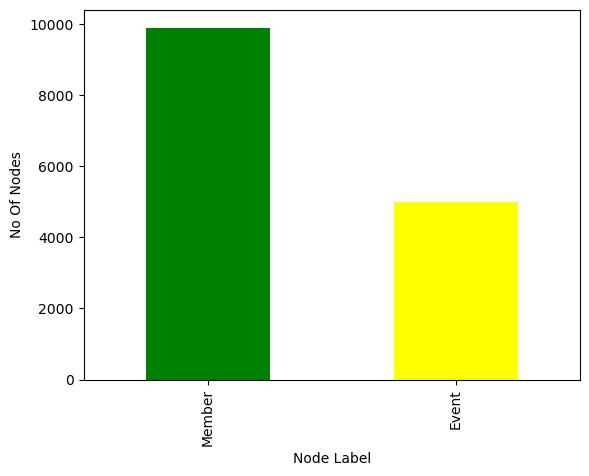

In [23]:
#Посмотрим отношение участников событий к самим событиям
df_result_count=pd.Series({"Member":count_m,"Event":count_e})
print(df_result_count)
df_result_count.plot(kind="bar",color=["green","yellow"])
plt.xlabel("Node Label")
plt.ylabel("No Of Nodes")
plt.show()

Событий меньше в ~ 2 раза, чем участников, однако не точно в 2 раза, а в 1,98 раза, можно предположить, что:
* есть участники, принимающие участие более, чем в 1ом событии,
* есть события, где принимает участие 1 участник, возможно есть пропуски в данных

In [24]:
#Посмотрим кто из нашей базы данных участвовал в более чем 1 событии.А также узнаем количество событий участника и Id события
query_string ='''
MATCH (m:Member)-[:PARTICIPATE]->(e:Event)
WITH m,collect(e.idEvent) as idEvent,count(*) as total
WHERE total >= 2
RETURN  m.fullname, idEvent,total
ORDER BY total DESC;
'''
data_total_event = conn.query(query_string, db='graphdb')
pd.DataFrame(data_total_event,columns=['FullName', 'idEvent', 'Total'])

,FullName,idEvent,Total
0,Ахромеева Алина Ивановна,"[42389, 53707, 59801, 61824, 89429, 90615, 128...",50
1,Башнина Антонина Глебовна,"[66267, 208421, 224711, 292757, 370508, 379611...",14
2,Медведева Дарья Алексеевна,"[87253, 109281, 173973, 196243, 327044, 580478]",6
3,Зимнухова Карина Даниловна,"[132775, 241336, 346700, 348716, 504411]",5
4,Диомидов Игорь Ильдарович,"[361353, 513700, 608245, 885195, 906600]",5
5,Шолохов Игорь Робертович,"[218462, 750824, 829652, 875321]",4
6,Двигубская Валентина Геннадьевна,"[218462, 355320, 798803]",3
7,Пафомова Кира Вадимовна,"[99439, 829652, 958318]",3
8,Ляуданский Валентин Владиславович,"[99439, 913605]",2
9,Мараховская Дарья Романовна,"[732922, 958318]",2


In [25]:
#Посмотрим есть ли в нашей базе данных такие участники, которые не приняли участия ни в одном событие. Наличие таких участников может говорить об ошибках в данных
query_string ='''
MATCH (m:Member)-[:PARTICIPATE]->(e:Event)
WITH m,collect(e.idEvent) as idEvent,count(*) as total
WHERE total < 1
RETURN  m.fullname, idEvent,total
ORDER BY total DESC;
'''
data_total_event = conn.query(query_string, db='graphdb')
pd.DataFrame(data_total_event,columns=['FullName', 'idEvent', 'Total'])

,FullName,idEvent,Total


In [26]:
#Посмотрим какие события имеют более чем 2ух участника, а также ФИО таких участников
query_string ='''
MATCH (m:Member)-[:PARTICIPATE]->(e:Event)
WITH e,collect(e.fullname) as fullname,count(*) as total
WHERE total > 2
RETURN e.idEvent, e.fullname1,e.fullname2, e.fullname3, e.fullname4, total
ORDER BY total DESC;
'''
data_total_full_name = conn.query(query_string, db='graphdb')
pd.DataFrame(data_total_full_name,columns=['idEvent', 'FullName1', 'FullName2','FullName3', 'FullName4', 'Total'])

,idEvent,FullName1,FullName2,FullName3,FullName4,Total
0,70049,Яшина Полина Евгеньевна,Герасимовская Ксения Дамировна,Федова Анжелика Вадимовна,Вальдовский Альберт Ефимович,4
1,92995,Журик Альберт Евгеньевич,Бадьянова Римма Максимовна,Кучеренко Ирина Ильинична,Болтик Григорий Максимович,4
2,938764,Солтаганов Федор Ефимович,Хрисогонов Иван Геннадьевич,Самолов Михаил Алексеевич,Двигубская Яна Ивановна,4
3,985851,Павлюкова Наталья Федоровна,Клебан Игорь Глебович,Липунова Галина Ринатовна,Ноткина Альбина Михаиловна,4
4,850472,Стрик Элина Марселевна,Борчин Павел Робертович,Ахромеева Алина Ивановна,Ларищев Илья Александрович,4
5,873359,Якимихина Наталья Яновна,Улиссов Марсель Эдуардович,Джанибеков Никита Юрьевич,Старовойтов Вячеслав Павлович,4
6,765223,Савлук Марсель Владимирович,Атамкулова Мария Андреевна,Бабосов Михаил Константинович,Гулева Марина Витальевна,4
7,716489,Пантелюхина Лариса Вячеславовна,Штин Максим Русланович,Адельханова Елена Петровна,Арсенчук Руслан Денисович,4
8,523688,Бацких Егор Олегович,Барилов Роман Филиппович,Ботяновская Антонина Даниловна,Памфилова Тамара Даниловна,4
9,551592,Захарьева Ирина Денисовна,Солонченко Карина Васильевна,Выборнов Дмитрий Дмитриевич,Нугуманов Ефим Андреевич,4


In [27]:
#Посмотрим есть ли такие события, где принимало участие менее 2ух человек
query_string ='''
MATCH (m:Member)-[:PARTICIPATE]->(e:Event)
WITH e,collect(e.fullname) as fullname,count(*) as total
WHERE total < 2
RETURN e.idEvent, e.fullname1,e.fullname2,e.fullname3,e.fullname4,total
ORDER BY total DESC;
'''
data_total_full_name = conn.query(query_string, db='graphdb')
pd.DataFrame(data_total_full_name,columns=['idEvent', 'FullName1', 'FullName2','FullName3','FullName4','Total'])

,idEvent,FullName1,FullName2,FullName3,FullName4,Total


## 3.1 Промежуточные выводы:
* С большой долей вероятности данные полные, отсутствуют ошибки,
* Стандартное событие содержит 2 участников, которые принимали участие только в 1 событии из базы данных
* 27 участников приняли участие более, чем в 1 событии,
* 15 событий имеют по 4 участника.
### На основе этой информации, мы можем предположить, что часть участников связаны с другими участниками не напрямую, а через других участников. Посмотрим, выведем граф со всеми участниками и их связями для участников кол-во событий >=2

In [28]:
#Данный запрос выводит все связанные ноды и связи для участников с количеством событий более или равном 2
query ='''
MATCH p = (member1:Member)-->(event:Event)<--(member2:Member)
WHERE member1.idEvent <> member2.idEvent
RETURN p;
'''
data_t=conn.query_graph(query, db='graphdb')
w = GraphWidget(graph=data_t)
w.set_node_color_mapping(lambda index, node: "blue" if node["properties"]["label"] == "Member" else "orange")
w.set_node_label_mapping(lambda index, node: node["properties"]["fullname"] if node["properties"]["label"] == "Member" else node["properties"]["idEvent"])
w.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

In [29]:
#Данный запрос выводит все события с количеством участников более 2
query ='''
MATCH p = (member1:Member)-->(event:Event)<--(member2:Member)
WHERE event.fullname3 IS NOT NULL
RETURN p;
'''
data_t=conn.query_graph(query, db='graphdb')
w = GraphWidget(graph=data_t)
w.set_node_color_mapping(lambda index, node: "blue" if node["properties"]["label"] == "Member" else "orange")
w.set_node_label_mapping(lambda index, node: node["properties"]["fullname"] if node["properties"]["label"] == "Member" else node["properties"]["idEvent"])
w.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

По данным графовым представлениям можно сделать вывод, что 15 событий являются наиболее значимыми, так как в них принимают участие не 2 участника, а 4. Так как все остальные 4970 событий содержат только 2 участников, такие события являются аномальными и на них стоит обратить особое внимание. 

In [30]:
#Запросим информацию о конкретном человеке и событиях, где он участвовал
query ='''
MATCH p = (m:Member)-[:PARTICIPATE]-(e)
WHERE m.fullname = 'Ахромеева Алина Ивановна'
RETURN p;
'''
data_ahromeeva = conn.query_graph(query, db='graphdb')
w = GraphWidget(graph=data_ahromeeva)
w.set_node_color_mapping(lambda index, node: "blue" if node["properties"]["label"] == "Member" else "orange")
w.set_node_label_mapping(lambda index, node: node["properties"]["fullname"] if node["properties"]["label"] == "Member" else node["properties"]["idEvent"])
w.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

In [31]:
#Запросим информацию о конкретном человеке, событиях, где он участвовал, а также участников этих событий
query ='''
MATCH p = (m:Member)-[*]-(e)
WHERE m.fullname = 'Ахромеева Алина Ивановна'
RETURN p;
'''
data_ahromeeva = conn.query_graph(query, db='graphdb')
w = GraphWidget(graph=data_ahromeeva)
w.set_node_color_mapping(lambda index, node: "blue" if node["properties"]["label"] == "Member" else "orange")
w.set_node_label_mapping(lambda index, node: node["properties"]["fullname"] if node["properties"]["label"] == "Member" else node["properties"]["idEvent"])
w.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

По данному графу, можно сделать вывод, что участник Ахромеева Алина Ивановна является центральным участником, через нее можно перейти к любому другому частнику графа. Можно предположить, что участник Ахромеева Алина Ивановна играет роль не просто участник событий, а в зависимости от типа событий организатор, мошенник, разносчик вируса и т.д.

In [33]:
#Запросим информацию о конкретном человеке, событиях, где он участвовал, а также участников этих событий
query ='''
MATCH p = (m:Member)-[*]-(e)
WHERE m.fullname = 'Башнина Антонина Глебовна'
RETURN p;
'''
data_ahromeeva = conn.query_graph(query, db='graphdb')
w = GraphWidget(graph=data_ahromeeva)
w.set_node_color_mapping(lambda index, node: "blue" if node["properties"]["label"] == "Member" else "orange")
w.set_node_label_mapping(lambda index, node: node["properties"]["fullname"] if node["properties"]["label"] == "Member" else node["properties"]["idEvent"])
w.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

По данному графу, можно сделать вывод, что участник Башнина Антонина Глебовна является центральным участником, через нее можно перейти к любому другому частнику графа. Можно предположить, что участник Башнина Антонина Глебовна играет роль не просто участник событий, а в зависимости от типа событий организатор, мошеник, разнощик вируса и т.д.

In [34]:
#Запросим информацию о конкретном человеке, событиях, где он участвовал, а также участников этих событий
query ='''
MATCH p = (m:Member)-[*]-(e)
WHERE m.fullname = 'Медведева Дарья Алексеевна'
RETURN p;
'''
data_ahromeeva = conn.query_graph(query, db='graphdb')
w = GraphWidget(graph=data_ahromeeva)
w.set_node_color_mapping(lambda index, node: "blue" if node["properties"]["label"] == "Member" else "orange")
w.set_node_label_mapping(lambda index, node: node["properties"]["fullname"] if node["properties"]["label"] == "Member" else node["properties"]["idEvent"])
w.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

По данному графу, можно сделать вывод, что участник Медведева Дарья Алексеевна является центральным участником, через нее можно перейти к любому другому частнику графа. Можно предположить, что участник Медведева Дарья Алексеевна играет роль не просто участник событий, а в зависимости от типа событий организатор, мошеник, разнощик вируса и т.д.

In [35]:
#Запросим информацию о конкретном человеке, событиях, где он участвовал, а также участников этих событий
query ='''
MATCH p = (m:Member)-[*]-(e)
WHERE m.fullname = 'Двигубская Валентина Геннадьевна'
RETURN p;
'''
data_ahromeeva = conn.query_graph(query, db='graphdb')
w = GraphWidget(graph=data_ahromeeva)
w.set_node_color_mapping(lambda index, node: "blue" if node["properties"]["label"] == "Member" else "orange")
w.set_node_label_mapping(lambda index, node: node["properties"]["fullname"] if node["properties"]["label"] == "Member" else node["properties"]["idEvent"])
w.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

По данному графу можно сделать вывод, что есть 3 наиболее значимых участника - Двигубская Валентина Геннадьевна, Шолохов Игорь Робертович и Пафомова Кира Вадимовна. Данные лица, участвовали более чем в 2ух событиях и с помощью них осуществилась связь частей графа. Также, можно предположить наличие 3ех сообществ.

In [36]:
#Запросим информацию о конкретном человеке, событиях, где он участвовал, а также участников этих событий
query ='''
MATCH p = (m:Member)-[*]-(e)
WHERE m.fullname = 'Зимнухова Карина Даниловна'
RETURN p;
'''
data_ahromeeva = conn.query_graph(query, db='graphdb')
w = GraphWidget(graph=data_ahromeeva)
w.set_node_color_mapping(lambda index, node: "blue" if node["properties"]["label"] == "Member" else "orange")
w.set_node_label_mapping(lambda index, node: node["properties"]["fullname"] if node["properties"]["label"] == "Member" else node["properties"]["idEvent"])
w.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

По данному графу можно сделать вывод, что есть 2 наиболее значимых участника - Диомидов Игорь Ильдарович, Зимнухова Карина Даниловна. Данные лица, участвовали более в 5 событиях и с помощью них осуществилась связь частей графа.

In [38]:
#Запросим информацию о конкретном человеке, событиях, где он участвовал, а также участников этих событий
query ='''
MATCH p = (m:Member)-[*]-(e)
WHERE m.fullname = 'Яцкой Роберт Ильдарович'
RETURN p;
'''
data_ahromeeva = conn.query_graph(query, db='graphdb')
w = GraphWidget(graph=data_ahromeeva)
w.set_node_color_mapping(lambda index, node: "blue" if node["properties"]["label"] == "Member" else "orange")
w.set_node_label_mapping(lambda index, node: node["properties"]["fullname"] if node["properties"]["label"] == "Member" else node["properties"]["idEvent"])
w.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

По данному графу можно предположить, что участники являются частью сообшества, или если это транзакции, то такие схемы могут использоваться для отмывания денег, но скорее присуще компаниям, нежели физическим лицам.

In [33]:
query_string ='''
MATCH (m:Member)-[:PARTICIPATE]->(:Event)<-[:PARTICIPATE]-(m2)
WHERE id(m) < id(m2)
WITH m,m2, count(*) AS common
RETURN count(*) AS numberOfRows;
'''
conn.query(query_string, db='graphdb')

[<Record numberOfRows=5060>]

In [63]:
#Выведем в формате json информацию о конкретном участники событий:событие, участник1, участник 2
query ='''
MATCH (member1:Member{fullname:'Башнина Антонина Глебовна'})-->(event:Event)<--(member2:Member)
RETURN member1.fullname AS Member1, member2.fullname AS Member2, event.idEvent AS idEvent;
'''
data_s=conn.query_json(query, db='graphdb')
data_s

'[{"Member1": "Башнина Антонина Глебовна", "Member2": "Купоров Григорий Станиславович", "idEvent": "292757"}, {"Member1": "Башнина Антонина Глебовна", "Member2": "Казак Николай Русланович", "idEvent": "918855"}, {"Member1": "Башнина Антонина Глебовна", "Member2": "Павлючиков Максим Филиппович", "idEvent": "66267"}, {"Member1": "Башнина Антонина Глебовна", "Member2": "Аргентовская Евгения Евгеньевна", "idEvent": "224711"}, {"Member1": "Башнина Антонина Глебовна", "Member2": "Фефилов Дмитрий Янович", "idEvent": "563736"}, {"Member1": "Башнина Антонина Глебовна", "Member2": "Алябышева Диана Ярославовна", "idEvent": "495988"}, {"Member1": "Башнина Антонина Глебовна", "Member2": "Акрамова Людмила Альбертовна", "idEvent": "484562"}, {"Member1": "Башнина Антонина Глебовна", "Member2": "Головушина Алла Филипповна", "idEvent": "385035"}, {"Member1": "Башнина Антонина Глебовна", "Member2": "Габов Борис Марселевич", "idEvent": "379611"}, {"Member1": "Башнина Антонина Глебовна", "Member2": "Сергул

In [14]:
query ='''
MATCH (member1:Member)-->(event:Event)<--(member2:Member)
WHERE ID(member1) = 341
RETURN member1.fullname AS Member1, member2.fullname AS Member2, event.idEvent AS idEvent;
'''
data_s=conn.query_json(query, db='graphdb')
data_s

'[{"Member1": "Башнина Антонина Глебовна", "Member2": "Купоров Григорий Станиславович", "idEvent": "292757"}, {"Member1": "Башнина Антонина Глебовна", "Member2": "Казак Николай Русланович", "idEvent": "918855"}, {"Member1": "Башнина Антонина Глебовна", "Member2": "Павлючиков Максим Филиппович", "idEvent": "66267"}, {"Member1": "Башнина Антонина Глебовна", "Member2": "Аргентовская Евгения Евгеньевна", "idEvent": "224711"}, {"Member1": "Башнина Антонина Глебовна", "Member2": "Фефилов Дмитрий Янович", "idEvent": "563736"}, {"Member1": "Башнина Антонина Глебовна", "Member2": "Алябышева Диана Ярославовна", "idEvent": "495988"}, {"Member1": "Башнина Антонина Глебовна", "Member2": "Акрамова Людмила Альбертовна", "idEvent": "484562"}, {"Member1": "Башнина Антонина Глебовна", "Member2": "Головушина Алла Филипповна", "idEvent": "385035"}, {"Member1": "Башнина Антонина Глебовна", "Member2": "Габов Борис Марселевич", "idEvent": "379611"}, {"Member1": "Башнина Антонина Глебовна", "Member2": "Сергул

In [48]:
#Выведем в формате json информацию о конкретном участники событий:участник, события, кол-во
query ='''
MATCH (member:Member{fullname:'Башнина Антонина Глебовна'})-[:PARTICIPATE]->(event:Event)
WITH member,collect(event.idEvent) as idEvent,count(*) as total
RETURN member.fullname AS Member, idEvent, total;
'''
data_s=conn.query_json(query, db='graphdb')
data_s

'[{"Member": "Башнина Антонина Глебовна", "idEvent": ["292757", "918855", "66267", "224711", "563736", "495988", "484562", "385035", "379611", "208421", "370508", "858935", "663659", "522249"], "total": 14}]'

In [64]:

query ='''
MATCH (member:Member{fullname:$name})-[:PARTICIPATE]->(event:Event)
WITH member,collect(event.idEvent) as idEvent,count(*) as total
RETURN member.fullname AS Member, idEvent, total;
'''
parametrs = {"name":"Башнина Антонина Глебовна"}
data_s=conn.query_json_id(query, parametrs, db='graphdb')
data_s

'[{"Member": "Башнина Антонина Глебовна", "idEvent": ["292757", "918855", "66267", "224711", "563736", "495988", "484562", "385035", "379611", "208421", "370508", "858935", "663659", "522249"], "total": 14}]'

# 4 Analysys with GDS

In [40]:
#Создаем пустую базу данных
conn.query("CREATE OR REPLACE DATABASE graphdb")

[]

In [41]:
#Создаем ноды и свойства участник события, используя информацию из файла data_test.csv
query_string = '''
LOAD CSV WITH HEADERS FROM
'https://raw.githubusercontent.com/KaterinaChel/grath-DB/main/data_test.csv'
AS line FIELDTERMINATOR ';'
MERGE (member:Member {fullname: line.FullName1})
  ON CREATE SET member.idEvent = line.idEvent
  on MATCH SET member.idEvent = apoc.convert.toSet(member.idEvent + [line.idEvent]) 
MERGE (member2:Member {fullname: line.FullName2})
  ON CREATE SET member2.idEvent = line.idEvent
  on MATCH SET member2.idEvent = apoc.convert.toSet(member2.idEvent + [line.idEvent]);
  
'''
conn.query(query_string, db='graphdb')

[]

In [42]:
#Создаем отношения участник события -[участвовал]->участик события
query_string ='''
LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/KaterinaChel/grath-DB/main/data_test.csv?token=GHSAT0AAAAAAB6WRB4BI7D3HNOJHAKWIKUQZAMF4NA' AS line FIELDTERMINATOR ';'
MATCH (member1:Member {fullname: line.FullName1})
MATCH (member2:Member {fullname: line.FullName2})
CREATE (member1)-[:PARTICIPATE]->(member2)
CREATE (member2)-[:PARTICIPATE]->(member1);
'''
conn.query(query_string, db='graphdb')

[]

In [43]:
gds = GraphDataScience(uri_my, auth=(user_my, password_my), database="graphdb")

In [44]:
gds.run_cypher("MATCH (n) return labels(n) as labels, count(*) as nodeCount")

,labels,nodeCount
0,[Member],9899


Создадим проекцию графа. Проекции графов полностью хранятся в памяти с использованием сжатых структур данных, оптимизированных для топологии и поиска свойств.

In [72]:
Member_relait, result = gds.graph.project("relait", "Member", "PARTICIPATE")
result

nodeProjection            {'Member': {'label': 'Member', 'properties': {}}}
relationshipProjection    {'PARTICIPATE': {'orientation': 'NATURAL', 'in...
graphName                                                            relait
nodeCount                                                              9899
relationshipCount                                                     10000
projectMillis                                                            19
Name: 0, dtype: object

In [73]:
wcc_memb = gds.wcc.stats(Member_relait)
wcc_memb

componentCount                                                        4903
componentDistribution    {'p99': 2, 'min': 2, 'max': 51, 'mean': 2.0189...
postProcessingMillis                                                     4
preProcessingMillis                                                      0
computeMillis                                                            8
configuration            {'jobId': '09719b09-6d0d-4907-8609-6e0238fbfac...
Name: 0, dtype: object

In [74]:
wcc_memb['componentDistribution']

{'p99': 2,
 'min': 2,
 'max': 51,
 'mean': 2.018967978788497,
 'p90': 2,
 'p50': 2,
 'p999': 7,
 'p95': 2,
 'p75': 2}

Статистически подтвердили, что среднее кол-во участников событий близко к 2. Посмотрели максиммальное, минимальное и рандомные значения

In [75]:
gds.graph.list()

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema,schemaWithOrientation
0,"{'p99': 1, 'min': 1, 'max': 50, 'mean': 1.0102...",myGraph,graphdb,2862 KiB,2931320,9899,10000,{'relationshipProjection': {'PARTICIPATE': {'o...,0.000102,2023-04-05T10:59:00.101376700+03:00,2023-04-05T10:59:00.112203100+03:00,"{'graphProperties': {}, 'relationships': {'PAR...","{'graphProperties': {}, 'relationships': {'PAR..."
1,"{'p99': 1, 'min': 1, 'max': 50, 'mean': 1.0102...",relait,graphdb,2862 KiB,2931320,9899,10000,{'relationshipProjection': {'PARTICIPATE': {'o...,0.000102,2023-04-05T11:11:32.244163400+03:00,2023-04-05T11:11:32.255993000+03:00,"{'graphProperties': {}, 'relationships': {'PAR...","{'graphProperties': {}, 'relationships': {'PAR..."


In [76]:
pagerank_df_member = gds.pageRank.stream(Member_relait)

In [83]:
pagerank_df_member.max()

nodeId    9898.000000
score       22.602141
dtype: float64

In [103]:
pagerank_df_member.sort_values(by = 'score', ascending=False)

,nodeId,score
221,221,22.602141
341,341,6.702704
873,873,3.169496
661,661,2.496732
1794,1794,2.496732
...,...,...
9202,9202,0.528422
8066,8066,0.528422
7993,7993,0.528422
8790,8790,0.528422


С помощью алгоритма pagerank мы можем определить центральные ноды, как и ожидалось, нода 221 - это Ахромеева Алина Ивановна.Все ноды с высоким показателем это выделенные ноды при визуальном осмотре графа - 
* Ахромеева Алина Ивановна,22.602140755580333
* Башнина Антонина Глебовна,6.702703810275546
* Медведева Дарья Алексеевна,3.169495600207817
* Диомидов Игорь Ильдарович,2.496731732954958
* Зимнухова Карина Даниловна,2.496731732954958
* Шолохов Игорь Робертович,1.5114704293475534
* Двигубская Валентина Геннадьевна,1.2016188887270551
* Пафомова Кира Вадимовна,1.1706822673166937


In [71]:
gds.graph.drop(Member_relait)

graphName                                                           relait
database                                                           graphdb
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                             9899
relationshipCount                                                    10000
configuration            {'relationshipProjection': {'PARTICIPATE': {'o...
density                                                           0.000102
creationTime                           2023-04-05T10:47:27.086869600+03:00
modificationTime                       2023-04-05T10:52:25.265706400+03:00
schema                   {'graphProperties': {}, 'relationships': {'PAR...
schemaWithOrientation    {'graphProperties': {}, 'relationships': {'PAR...
Name: 0, dtype: object